## Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
def Normalize_Calculation(dataset):
  train_transform = transforms.Compose([transforms.ToTensor()])
  train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
  mean = train_set.data.mean(axis=(0,1,2))/255
  std = train_set.data.std(axis=(0,1,2))/255
  return mean, std

mean,std = Normalize_Calculation(datasets.CIFAR10)
print("Mean - ", mean,"  ","Standard Deviation - ",std)

Files already downloaded and verified
Mean -  [0.49139968 0.48215841 0.44653091]    Standard Deviation -  [0.24703223 0.24348513 0.26158784]


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)
                                       ])

# Dataset and Creating Train/Test Split

In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)
# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

# The model
Let's start with the model we first saw

In [6]:
dropout_value = 0.01

def norm_layer(norm, parameter):
    if norm == "BN":
        return(nn.BatchNorm2d(parameter[0]))
    elif norm == "LN":
        return(nn.GroupNorm(1,parameter[0]))
    else:
        raise ValueError('Options are BN / LN / GN')


class Net(nn.Module):
    def __init__(self, norm="LN"):
        super(Net, self).__init__()
        self.norm = norm

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=1,bias = False),
            norm_layer(self.norm, [8, 32, 32]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1,bias = False),
            norm_layer(self.norm, [16, 32, 32]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.tr1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0,bias = False),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1,bias = False),
            norm_layer(self.norm, [16, 16, 16]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1,bias = False),
            norm_layer(self.norm, [32, 16, 16]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1,bias = False),
            norm_layer(self.norm, [32, 16, 16]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        self.tr2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0,bias = False),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0,bias = False),
            norm_layer(self.norm, [16, 8, 6]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0,bias = False),
            norm_layer(self.norm, [32, 6, 4]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0,bias = False),
            norm_layer(self.norm, [64, 4, 2]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2)
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0,bias = False),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(dropout_value)
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        x = self.tr1(x)
        x = self.pool1(x)

        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)

        x = self.tr2(x)
        x = self.pool2(x)

        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
         GroupNorm-2            [-1, 8, 32, 32]              16
           Dropout-3            [-1, 8, 32, 32]               0
              ReLU-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
         GroupNorm-6           [-1, 16, 32, 32]              32
           Dropout-7           [-1, 16, 32, 32]               0
              ReLU-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             128
             ReLU-10            [-1, 8, 32, 32]               0
        MaxPool2d-11            [-1, 8, 16, 16]               0
           Conv2d-12           [-1, 16, 16, 16]           1,152

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))


# Let's Train and test our model

In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.6042988300323486 Batch_id=390 Accuracy=29.30: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s]



Test set: Average loss: 0.0137, Accuracy: 3701/10000 (37.01%)

EPOCH: 1


Loss=1.6658064126968384 Batch_id=390 Accuracy=42.75: 100%|██████████| 391/391 [00:23<00:00, 16.47it/s]



Test set: Average loss: 0.0117, Accuracy: 4625/10000 (46.25%)

EPOCH: 2


Loss=1.1675865650177002 Batch_id=390 Accuracy=48.80: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s]



Test set: Average loss: 0.0112, Accuracy: 4859/10000 (48.59%)

EPOCH: 3


Loss=1.330176830291748 Batch_id=390 Accuracy=53.55: 100%|██████████| 391/391 [00:22<00:00, 17.22it/s]



Test set: Average loss: 0.0097, Accuracy: 5654/10000 (56.54%)

EPOCH: 4


Loss=1.2184498310089111 Batch_id=390 Accuracy=57.74: 100%|██████████| 391/391 [00:22<00:00, 17.49it/s]



Test set: Average loss: 0.0087, Accuracy: 6084/10000 (60.84%)

EPOCH: 5


Loss=0.9455541372299194 Batch_id=390 Accuracy=61.15: 100%|██████████| 391/391 [00:21<00:00, 18.46it/s]



Test set: Average loss: 0.0092, Accuracy: 5852/10000 (58.52%)

EPOCH: 6


Loss=1.08274507522583 Batch_id=390 Accuracy=63.81: 100%|██████████| 391/391 [00:21<00:00, 18.59it/s]



Test set: Average loss: 0.0084, Accuracy: 6314/10000 (63.14%)

EPOCH: 7


Loss=1.1514601707458496 Batch_id=390 Accuracy=65.62: 100%|██████████| 391/391 [00:20<00:00, 18.62it/s]



Test set: Average loss: 0.0077, Accuracy: 6630/10000 (66.30%)

EPOCH: 8


Loss=1.0937609672546387 Batch_id=390 Accuracy=67.57: 100%|██████████| 391/391 [00:21<00:00, 17.94it/s]



Test set: Average loss: 0.0074, Accuracy: 6762/10000 (67.62%)

EPOCH: 9


Loss=0.9729010462760925 Batch_id=390 Accuracy=69.00: 100%|██████████| 391/391 [00:22<00:00, 17.49it/s]



Test set: Average loss: 0.0072, Accuracy: 6793/10000 (67.93%)

EPOCH: 10


Loss=0.6909819841384888 Batch_id=390 Accuracy=69.82: 100%|██████████| 391/391 [00:23<00:00, 16.45it/s]



Test set: Average loss: 0.0069, Accuracy: 6990/10000 (69.90%)

EPOCH: 11


Loss=1.0842257738113403 Batch_id=390 Accuracy=70.89: 100%|██████████| 391/391 [00:22<00:00, 17.64it/s]



Test set: Average loss: 0.0072, Accuracy: 6820/10000 (68.20%)

EPOCH: 12


Loss=0.7611087560653687 Batch_id=390 Accuracy=71.83: 100%|██████████| 391/391 [00:21<00:00, 18.20it/s]



Test set: Average loss: 0.0068, Accuracy: 7014/10000 (70.14%)

EPOCH: 13


Loss=0.9600452184677124 Batch_id=390 Accuracy=72.17: 100%|██████████| 391/391 [00:21<00:00, 18.46it/s]



Test set: Average loss: 0.0066, Accuracy: 7086/10000 (70.86%)

EPOCH: 14


Loss=0.8330914378166199 Batch_id=390 Accuracy=73.60: 100%|██████████| 391/391 [00:21<00:00, 18.53it/s]



Test set: Average loss: 0.0067, Accuracy: 7058/10000 (70.58%)

EPOCH: 15


Loss=0.7309578657150269 Batch_id=390 Accuracy=73.95: 100%|██████████| 391/391 [00:22<00:00, 17.63it/s]



Test set: Average loss: 0.0063, Accuracy: 7228/10000 (72.28%)

EPOCH: 16


Loss=0.7986281514167786 Batch_id=390 Accuracy=74.97: 100%|██████████| 391/391 [00:22<00:00, 17.40it/s]



Test set: Average loss: 0.0069, Accuracy: 6959/10000 (69.59%)

EPOCH: 17


Loss=0.5056904554367065 Batch_id=390 Accuracy=75.14: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]



Test set: Average loss: 0.0064, Accuracy: 7275/10000 (72.75%)

EPOCH: 18


Loss=0.44113388657569885 Batch_id=390 Accuracy=75.93: 100%|██████████| 391/391 [00:21<00:00, 17.81it/s]



Test set: Average loss: 0.0062, Accuracy: 7269/10000 (72.69%)

EPOCH: 19


Loss=0.738027036190033 Batch_id=390 Accuracy=76.06: 100%|██████████| 391/391 [00:21<00:00, 18.10it/s]



Test set: Average loss: 0.0063, Accuracy: 7274/10000 (72.74%)



Text(0.5, 1.0, 'Test Accuracy')

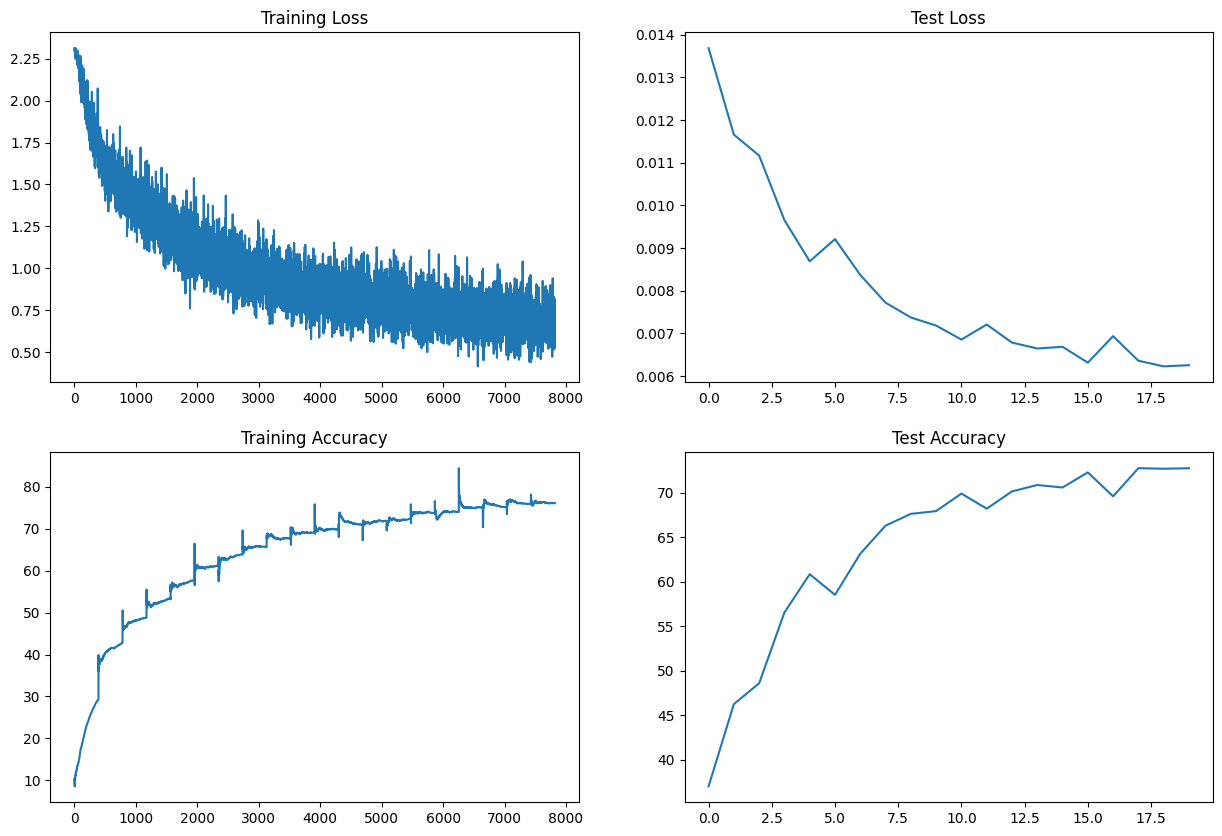

In [10]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")